In [2]:
#on importe les fonctions nécessaires pour la suite

import autograd
from autograd import numpy as np
from numpy.polynomial import Polynomial
from math import sqrt
import matplotlib.pyplot as plt

On pose g:t-->f(0,t). La condition raisonnable est que c soit compris entre g(0) et g(1). En effet, f est 
continuement différentiable, donc continue. On peut appliquer le TVI sur l'intervalle [0;1].

In [3]:
def find_seed(g, c=0, a=0, b=1, eps=2**(-26)):
    
    """On réalise une dichotomie pour trouver une racine de g(t)-c. Les paramètres de la fonction ont été
    légèrement modifiés afin qu'elle soit plus facilement utilisable par la suite."""
    
    t = (a+b)/2
    
    if g(a) > g(b):
        if c > g(a) or c < g(b):
            return(None)
        
        while b-a > eps: #on veut une précision inférieure à eps
            if g(t) > c:
                a = t
            else:
                b = t
            t = (a+b)/2

    else :
        if c < g(a) or c > g(b):
            return(None)
        
        while b-a > eps:
            if g(t) > c:
                b = t
            else:
                a = t
            t = (a+b)/2
            
    return(t)


L'algorithme précédent fonctionne, mais il ne permet pas de traiter tous les types de courbes (ligne de niveau qui fait "demi-tour"). Il faut donc modifier l'algorithme en passant par une autre méthode. Nous allons utiliser le gradient de la fonction f : les lignes de niveau sont perpendiculaires au gradient. A chaque point, on calcule le gradient local [a;b] et on veut que le nouveau point [x[n];y[n]] vérifie deux conditions :

a*(x[n]-x[n-1]) + b*(y[n]-y[n-1]) = 0 (1) (ligne de niveau perpendiculaire au gradient)

(x[n]-x[n-1])^2 + (y[n]-y[n-1])^2 = delta^2 (2) (le nouveau point appartient au cercle de rayon delta et de centre l'ancien point ; ainsi on est sûrs que la distance entre deux points sera de delta). 

On va résoudre ce système à l'aide des polynômes Python.
Il va falloir choisir entre les deux solutions proposées.


In [4]:
def le_plus_loin(X, Y, x1, x2, y1, y2):
    """On va faire appel à cette fonction pour déterminer laquelle des deux solutions garder ; son principe est
    explicité par la suite"""
    
    
    x = X[-2]
    y = Y[-2]
    d1 = (x1-x)**2 + (y1-y)**2
    d2 = (x2-x)**2 + (y2-y)**2
    if d1 > d2:
        return(x1, y1)
    return(x2, y2)

In [5]:
def grad_f(f,x,y):
    """La fonction pour calculer le gradient d'une fonction à deux variables"""
    g = autograd.grad
    return(np.r_[g(f,0)(x,y),g(f,1)(x,y)])

In [6]:
def simple_contour(f, c=0.0, delta=0.01):
    X = []
    Y = []
    g = lambda t: f(0.0,t)
    X.append(0.0)
    Y.append(find_seed(g, c, 2**(-26)))
    if Y[-1] == None:
        return([], [])
    
    for k in range(5000): #condition d'arrêt, pas encore optimale
        
        a,b = grad_f(f,X[-1],Y[-1])
        x0 = X[-1]
        y0 = Y[-1]
   

#on va se servir des polynômes Python afin de résoudre le système de 2 équations à 2 inconnues explicité plus haut.

        if abs(a) >= (2**-13) : #si a est trop petit, le coefficient directeur de la droite sera disproportionné
                                #par rapport à l'ordonnée à l'origine de la droite
             p = Polynomial([y0**2-(delta*a/b)**2, -2*y0, 1])
             y1, y2 = p.roots()
             
             if y1.imag != 0.0:
                 return(X,Y) #il n'y a plus de solution
             
             x1 = x0-b*(y1-y0)/a
             x2 = x0-b*(y2-y0)/a
                
             if k == 0:
            #on verra dans la suite que notre fonction le_plus_loin nécessite d'avoir 2 points dans X et Y
            #on initialise donc manuellement le_plus_loin en choisissant arbitrairement le sens de parcours
                y = max(y1,y2)
                Y.append(y)
                X.append(x0-b*(y-y0)/a)
                
                
#On a deux solutions au système (rang n+1), on veut n'en garder qu'une. On regarde quel point est le plus éloigné 
#du point trouvé au rang n-1, pour s'assurer qu'on ne revient pas en arrière. Pour cela on utilise 
#le_plus_loin, définie plus haut.


             else:
                x, y = le_plus_loin(X, Y, x1, x2, y1, y2)
            
             
             
#Problème : le point trouvé peut être en réalité assez éloigné de la courbe de niveau, à cause de variations
#fortes de f. Pour y remédier, nous proposons la démarche suivante :
#On a trouvé "vers où" se situait notre prochain point. On va parcourir le cercle de centre X[-1] et de 
#rayon delta uniquement du côté de la courbe qui nous intéresse, i.e à droite où à gauche du gradient. 
#Pour ce faire,on passe en coordonnées polaires : x = rcos(teta) et y = rsin(teta). Avec r la distance algébrique 
#entre nos 2 points (ce qui nous permet d'être d'un côté ou de l'autre) et teta variant de alpha - pi/2 à 
#alpha + pi/2, alpha étant l'angle entre la tangente à la courbe et l'axe des abscisses. 
#En définissant ansi teta, on est sûr de parcourir le demi-cercle de base le gradient.
             
                alpha = np.arcsin(a/sqrt(a**2+b**2))
             
                sgn = np.sign(x-x0) # on détermine la direction vers laquelle se déplacer
                r = sgn*delta
                g = lambda theta: f(x0 + r*np.cos(theta),y0 + r*np.sin(theta))
             
                theta = find_seed(g, c, alpha-np.pi/2., alpha+np.pi/2, 2**(-26))
                
                x = x0 + r*np.cos(theta)
                y = y0 + r*np.sin(theta)
             
                X.append(x)
                Y.append(y)

        elif b != 0.0:
#d'après l'équation (1) (cf plus haut) y = y0
             Y.append(y0)
             p = Polynomial([x0**2-delta**2, -2*x0, 1])
             if len(p.roots()) == 2:
                 x1, x2 = p.roots()
             
                 if x1.imag != 0.0:
                     Y.pop()
                     return(X,Y)
            
                 if k == 0:
                    X.append(max(x1,x2))
             
                
                 else:
                
                    x, z = le_plus_loin(X, Y, x1, x2, y0, y0)
             
                    sgn = np.sign(x-x0) # on détermine la direction vers laquelle se déplacer
                    r = sgn*delta
                    g = lambda teta: f(r*np.cos(teta),r*np.sin(teta))
             
                    theta = find_seed(g, c, 0.0, np.pi, 2**(-26))
                    
                    x = x0 + r*np.cos(theta)
             
                    X.append(x)
             else:
                x = p.roots()
                if x.imag != 0.0:
                    return(X,Y)
                else:
                    X.append(x)
             
        elif b == 0.0:
             return(X, Y)
    
    return(X, Y)
                   

Testons maintenant nos algorithmes avec plusieurs fonctions

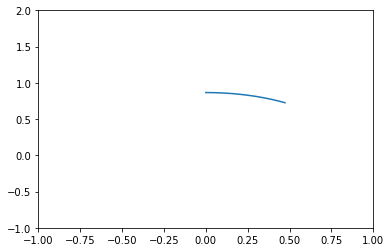

In [7]:
def cercle(x,y):
    return(x**2+y**2)

def h(x,y):
    return(x**2+2*y)

X, Y = simple_contour(cercle, 0.75, 0.0001)
plt.plot(X,Y)
plt.axis([-1,1,-1,2])
plt.show()


Observations: on trace (enfin) ce qui s'apparente à un arc de cercle. Donc notre programme tourne. Cependant, après tests, on se rend compte qu'il ne peut nous fournir un trop grand nombre de points: en effet, à partir d'un certain nombre de points (5000 environ), la fonction find_seed renvoie None. Une explication serait que notre méthode n'est pas assez précise: au bout d'un certain nombre d'itérations, on s'éloigne trop de la courbe de niveau recherchée et notre fonction ne peut donc plus trouver de solution.

On ajoute ci-dessous la fonction contour fournie par M. Boisgerault

In [ ]:
# Rotators
# ------------------------------------------------------------------------------
LEFT, UP, RIGHT, DOWN = 0, 1, 2, 3  # clockwise


def rotate_direction(direction, n=1):
    return (direction + n) % 4


def rotate(x, y, n=1):
    if n == 0:
        return x, y
    elif n >= 1:
        return rotate(1 - y, x, n - 1)
    else:
        assert n < 0
        return rotate(x, y, n=-3 * n)


def rotate_function(f, n=1):
    def rotated_function(x, y):
        xr, yr = rotate(x, y, -n)
        return f(xr, yr)

    return rotated_function


# Complex Contouring
# ------------------------------------------------------------------------------

# Customize the simple_contour function used in contour :
# simple_contour = smart_simple_contour


def contour(f, c, xs=[0.0, 1.0], ys=[0.0, 1.0], delta=0.01):
    curves = []
    nx, ny = len(xs), len(ys)
    for i in range(nx - 1):
        for j in range(ny - 1):
            xmin, xmax = xs[i], xs[i + 1]
            ymin, ymax = ys[j], ys[j + 1]

            def f_cell(x, y):
                return f(xmin + (xmax - xmin) * x, ymin + (ymax - ymin) * y)

            done = set()
            for n in [0, 1, 2, 3]:
                if n not in done:
                    rotated_f_cell = rotate_function(f_cell, n)
                    x_curve_r, y_curve_r = simple_contour(rotated_f_cell, c, delta)
                    exit = None
                    if len(x_curve_r) >= 1:
                        xf, yf = x_curve_r[-1], y_curve_r[-1]
                        if xf == 0.0:
                            exit = LEFT
                        elif xf == 1.0:
                            exit = RIGHT
                        elif yf == 0.0:
                            exit = DOWN
                        elif yf == 1.0:
                            exit = UP
                    if exit is not None:  # a fully successful contour fragment
                        exit = rotate_direction(exit, n)
                        done.add(exit)

                    x_curve, y_curve = [], []
                    for x_r, y_r in zip(x_curve_r, y_curve_r):
                        x, y = rotate(x_r, y_r, n=-n)
                        x_curve.append(x)
                        y_curve.append(y)
                    x_curve = np.array(x_curve)
                    y_curve = np.array(y_curve)
                    curves.append(
                        (xmin + (xmax - xmin) * x_curve, ymin + (ymax - ymin) * y_curve)
                    )
    return curves

Testons là sur nos fonctions:

In [ ]:
contour(cercle, 0.75)